# FFNN
This trains a classifier for the iris dataset.
Initially keras, matplotlib and numpy are imported

In [1]:
using Plots
using MXNet
using DataFrames

## Opening the csv and splitting into inputs and outputs
Using DataFrames for the initial list import simple to see that just column 4 need be selected for the outputs

In [2]:
df = readtable("data.csv", header=false)

,x1,x2,x3,x4,x5
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa
6,5.4,3.9,1.7,0.4,Iris-setosa
7,4.6,3.4,1.4,0.3,Iris-setosa
8,5.0,3.4,1.5,0.2,Iris-setosa
9,4.4,2.9,1.4,0.2,Iris-setosa
10,4.9,3.1,1.5,0.1,Iris-setosa


# Data preparation
Shuffle the data and split it into inputs and outputs where outputs are `(0,0,0)`, `(0,1,0)`, `(0,0,1)` which requires conversion from the strings which will be done via a comprehension and a dictionary to create the array of arrays. This can be turned into a 2D matrix via splatting the output and using hcat where each column is a new input.
It is important to note that 

In [3]:
df = df[randperm(size(df)[1]), :]
inputs = convert(Array{Float32}, df[1:4])'
keydict = Dict("Iris-setosa" => [0,0,0], "Iris-versicolor" => [0,1,0], "Iris-virginica" => [0,0,1])
outputs = Array{Float64}[keydict[key] for key in convert(Array, df[end])]
outputs = hcat(outputs...);

## Turning raw data into a data provider
MXNet uses data providers instead of just allowing raw arrays. This adds a slight complication if you are just using normal arrays of data. However, if you are streaming data or have real-time data, being able to construct your own data provider for the task adds significant power worth the slight annoyance. Unfortunately, via this method there is also no automated split of data as in keras. Your data sets need to be manually split. We will use 20% of the data as validation data.
The input and output symbols are where the data providers and the models match together. By using the same symbols the provider will send data from each symbol in the provider to the correspoinding symbol in the model.

In [4]:
split_index = round(Int, size(outputs)[end] * 0.8)
batchsize = 5
inputSymbol = :input
outputSymbol = :output
trainprovider = mx.ArrayDataProvider(inputSymbol => inputs[:, 1:split_index], batch_size=batchsize, 
    shuffle=true, outputSymbol => outputs[:, 1:split_index])
evalprovider = mx.ArrayDataProvider(inputSymbol => inputs[:, split_index+1:end], batch_size=batchsize, 
    shuffle=true, outputSymbol => outputs[:, split_index+1:end]);

# Setup model
For the model there needs to be two variables, the input and the output. You could have more variables depending on if you wanted an auxiliary output or input at a different stage in the model. For this example it will be a plain feedforward model with only single input and output datasets. The inputs and outputs rely on the same symbols beiung used as for the datasets so the data providers know where each part of the data is to be used.

In [5]:
input = mx.Variable(inputSymbol)
output = mx.Variable(outputSymbol)
mlp = @mx.chain input =>
    mx.MLP([7,3]) =>
    mx.LogisticRegressionOutput(output)

model = mx.FeedForward(mlp, context=mx.cpu());

# Setup optimiser
Here the optimiser is selected and initialised. The learning rarte is set to be `0.01`. A more complex learning rate would use a scheduler for the learning rate that lowers the learning rate with the number of epochs.

In [6]:
optimiser = mx.SGD();

# Fit model
Here the training is setup and run. the model, optimiser and training data provider are basic requriements for the `mx.fit` function. the defaults are changed to use the mean squared error for evaluation, including a validation dataset and initialising the neurons between -5,5.

In [7]:
epochmetrics = Float64[]
callback = mx.every_n_epoch((x,y,metric) -> push!(epochmetrics, metric[1][2]), 1, call_on_0=false)
mx.fit(model, optimiser, trainprovider, eval_data=evalprovider, verbosity=0,
    n_epoch=1000, eval_metric=mx.MSE(), initializer=mx.UniformInitializer(1), callbacks=[callback])


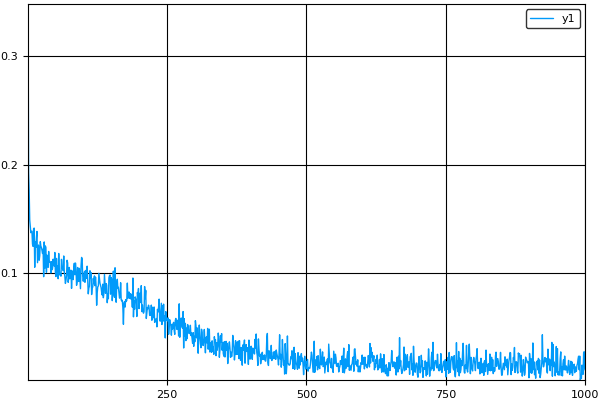

In [8]:
plot(epochmetrics)

# Testing
Finally, compare the predicted outputs to the expected outputs and see the actual real world performance.
We create a new data provider which contains the data only then do a simlpe comparison and print the total number of correct values.

In [9]:
inputdata = mx.ArrayDataProvider(inputSymbol => inputs)
outs = round(Int, mx.predict(model, inputdata))
correct = 0
for i = 1:size(outs)[2]
    if outs[:,i] == outputs[:,i]
        correct += 1
    end
end
correct

INFO: TempSpace: Total 0 MB allocated on CPU0


147